In [1]:
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck13, z_at_value
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np
# %matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm
import subprocess
import os

In [2]:
cosmo = Planck13

In [3]:
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0

In [4]:
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [5]:
# OLD
# def add_dist(df, H0, Om, Ol):
#     with open('z_file.txt', 'w') as f:
#         zs = df.Z
#         for i in range(len(zs)):
#             f.write(f'{zs[i]}\n')
#     os.system(
#         f'./_disperse_03/bin/my_dist {str(Om)} {str(Ol)} 0.0 {str(H0 / 100)} z_file.txt dist_file.txt'
#     )
#     dists = []
#     with open('dist_file.txt', 'r') as f:
#         for line in f:
#             dists.append(float(line))
# #     os.system(
# #         f'rm z_file.txt dist_file.txt'
# #     )        
#     df = df.assign(dist=dists)
#     return df

In [6]:
# OLD
# def add_cart_coords(df):
#     CX = []
#     CY = []
#     CZ = []
#     RA = df.RA
#     DEC = df.DEC
#     dist = df.dist
#     for i in range(len(RA)):
#         x = dist[i] * np.cos(RA[i] * np.pi / 180) * np.cos(DEC[i] * np.pi / 180)
#         y = dist[i] * np.sin(RA[i] * np.pi / 180) * np.cos(DEC[i] * np.pi / 180)
#         z = dist[i] * np.sin(DEC[i] * np.pi / 180)
#         CX.append(x)
#         CY.append(y)
#         CZ.append(z)
#     df = df.assign(CX=CX)
#     df = df.assign(CY=CY)
#     df = df.assign(CZ=CZ)
#     return df

In [7]:
def sph2cart(ra, dec, z):
    uniq_a = []
    uniq_d = {}
    for i in range(len(ra)):
        t = (ra[i], dec[i], z[i])
        if t not in uniq_d:
            uniq_d[t] = None
            uniq_a.append(t)
    with open('sph.txt', 'w') as f:
        f.write('# ra dec z\n')
        for i in range(len(uniq_a)):
            f.write(f'{uniq_a[i][0]}\t{uniq_a[i][1]}\t{uniq_a[i][2]}\n')
    os.system(
        f'_disperse_03/bin/delaunay_3D sph.txt -btype void -cosmo {Om} {Ol} {Ok} {H0 / 100} {-1.0} -minimal'
    )
    os.system(
        f'_disperse_03/bin/netconv sph.txt.NDnet -to NDnet_ascii'
    )
    
    CX = []
    CY = []
    CZ = []
    with open('sph.txt.NDnet.a.NDnet', 'r') as f:
        for i in range(4):
            f.readline()
        n = int(f.readline())
        if n != len(uniq_a):
            print('ERROR!')
            return
        for i in range(n):
            cx, cy, cz = tuple(map(float, f.readline().split()))
            uniq_d[uniq_a[i]] = (cx, cy, cz)
            
    
    for i in range(len(ra)):
        t = (ra[i], dec[i], z[i])
        t = uniq_d[t]
        CX.append(t[0])
        CY.append(t[1])
        CZ.append(t[2])
    os.system('rm sph.*')
    return CX, CY, CZ

In [8]:
!ls

 140521692909680_galaxies_ascii.txt
 140521692909680_galaxies_ascii.txt.NDnet
 140521692909680_galaxies_ascii.txt.NDnet.MSC
 140521692909680_galaxies_ascii.txt.NDnet_s3.up.NDskl
 140521692909680_galaxies_ascii.txt.NDnet_s3.up.NDskl.BRK.RaDecZ.a.NDskl
'CART_MGS_cart_smooth:1_s:3_board:smooth_comaZ:0.00545|0.04135_V:03'
 clusters_filtered_RaDecZ.csv
'COEF*R500 -- conn_clusters'
 coma_filtered_RaDecZ.csv
'coma_MGS_RaDecZ_dist_XYZ:0.00|0.06.csv'
 _disperse_01
 _disperse_02
 _disperse_03
 _disperse_04
 DisPerSe.ipynb
 disperse_MGS_coma_2D.ipynb
 disperse_MGS_coma_cart.ipynb
 disperse_MGS_coma.ipynb
 disperse.py
 disperse_sdss7_coma.ipynb
 main.ipynb
 MCXC.txt
 MGS
'MGS_cart_smooth:1_s:2_board:smooth_comaZ:0.00545|0.04135_V:03'
'MGS_cart_smooth:1_s:3_board:smooth_comaZ:0.00545|0.04135_V:03'
 MGS_coma_ascii.txt
'MINIMAL_MGS_cart_smooth:1_s:3_board:smooth_comaZ:0.00545|0.04135_V:03'
'OLD_coma_MGS_RaDecZ_XYZ:0.00|0.06.csv'
 __pycache__
'RaDecZ_MGS_cart_smooth:1_s:3_board:smooth_comaZ:0.00545|0.

In [9]:
!ls MGS

main_gals-DR123a.fit  main_gals-DR5.fit  main_gals-EXTRA.fit
main_gals-DR123b.fit  main_gals-DR6.fit  main_gals-SPECIALa.fit
main_gals-DR4.fit     main_gals-DR7.fit  main_gals-SPECIALb.fit


In [10]:
folder = 'MGS'
files = [
    'main_gals-DR123a.fit', 
    'main_gals-DR123b.fit',
    'main_gals-DR4.fit',
    'main_gals-DR5.fit',
    'main_gals-DR6.fit',
    'main_gals-DR7.fit'
]

In [11]:
t = Table.read(folder+'/'+files[0], format='fits')
sorted(list(t.columns))

['ab_dev',
 'ab_deverr',
 'ab_exp',
 'ab_experr',
 'b',
 'blueslope',
 'camcol',
 'catid',
 'class',
 'colc',
 'colcerr',
 'colv',
 'colverr',
 'contchi2',
 'counts_dev',
 'counts_deverr',
 'counts_exp',
 'counts_experr',
 'counts_model',
 'counts_modelerr',
 'dec',
 'deriv2',
 'dev_l',
 'dev_lnl',
 'devaucl',
 'diag_dec',
 'diag_primtarget',
 'diag_ra',
 'diag_sectarget',
 'eclass',
 'ecoeff1',
 'ecoeff2',
 'ecoeff3',
 'ecoeff4',
 'ecoeff5',
 'eta',
 'exp_l',
 'exp_lnl',
 'expl',
 'fibercounts',
 'fibercountserr',
 'fiberid',
 'field',
 'firstdelta',
 'firsteta',
 'firstid',
 'firstint',
 'firstlambda',
 'firstmajor',
 'firstmatch',
 'firstminor',
 'firstpa',
 'firstpeak',
 'firstrms',
 'flags',
 'flags2',
 'fracpsf',
 'galclass',
 'griflux',
 'grisn',
 'holetype',
 'id',
 'iso_a',
 'iso_aerr',
 'iso_agrad',
 'iso_b',
 'iso_berr',
 'iso_bgrad',
 'iso_colc',
 'iso_colcerr',
 'iso_colcgrad',
 'iso_phi',
 'iso_phierr',
 'iso_phigrad',
 'iso_rowc',
 'iso_rowcerr',
 'iso_rowcgrad',
 'l',
 

In [12]:
dfs = []
for file in files:
    data = Table.read(folder+'/'+file, format='fits')
    df = data[['ra', 'dec', 'zfinal', 'zconffinal', 'zwarning']].to_pandas()
    dfs.append(df)

In [13]:
full = pd.concat(dfs)

In [14]:
full

,ra,dec,zfinal,zconffinal,zwarning
0,146.714217,-1.041278,0.021265,0.998093,0
1,146.744138,-0.652219,0.203789,0.999300,0
2,146.628573,-0.765148,0.064672,0.998981,0
3,146.631654,-0.988261,0.052667,0.978025,0
4,146.919453,-0.990526,0.213949,0.984952,0
...,...,...,...,...,...
112196,260.743174,31.944035,0.033893,0.999611,0
112197,260.800576,31.898992,0.159699,0.999659,0
112198,260.716009,32.024276,0.167412,0.999942,0
112199,260.697236,32.285628,0.111586,0.999824,0


In [15]:
filtered = full.loc[full['zwarning'] == 0]
filtered = filtered.loc[filtered['zconffinal'] > 0.35]
filtered = filtered.loc[filtered['zfinal'] > 0.0]
filtered = filtered.loc[filtered['ra'] > 90]
filtered = filtered.loc[filtered['ra'] < 300]
# filtered = filtered.loc[filtered['dec'] > 0]
filtered = filtered.loc[(filtered['dec'] + 1.35*filtered['ra']-400) < 0]
filtered

,ra,dec,zfinal,zconffinal,zwarning
0,146.714217,-1.041278,0.021265,0.998093,0
1,146.744138,-0.652219,0.203789,0.999300,0
2,146.628573,-0.765148,0.064672,0.998981,0
3,146.631654,-0.988261,0.052667,0.978025,0
4,146.919453,-0.990526,0.213949,0.984952,0
...,...,...,...,...,...
112196,260.743174,31.944035,0.033893,0.999611,0
112197,260.800576,31.898992,0.159699,0.999659,0
112198,260.716009,32.024276,0.167412,0.999942,0
112199,260.697236,32.285628,0.111586,0.999824,0


In [16]:
# fig = plt.figure(figsize=(18, 12))
# plt.scatter(filtered[['ra']], filtered[['dec']], s=2)
# x = np.linspace(100.,300.)
# k, b = -1.35, 400
# plt.plot(x, k*x+b, color='r')
# plt.xlim(100, 300)
# plt.ylim(-10, 80)

In [17]:
filtered_rdz = filtered[['ra', 'dec', 'zfinal']]
filtered_rdz.columns = ['RA', 'DEC', 'Z']
filtered_rdz

,RA,DEC,Z
0,146.714217,-1.041278,0.021265
1,146.744138,-0.652219,0.203789
2,146.628573,-0.765148,0.064672
3,146.631654,-0.988261,0.052667
4,146.919453,-0.990526,0.213949
...,...,...,...
112196,260.743174,31.944035,0.033893
112197,260.800576,31.898992,0.159699
112198,260.716009,32.024276,0.167412
112199,260.697236,32.285628,0.111586


In [18]:
coma_ra_int = (120, 280)
coma_dec_int = (-20, 80)
coma_z_int = (0.000, 0.060)
# coma_z_int = (0.006, 0.040)

coma = filtered_rdz[
        (coma_ra_int[0] < filtered_rdz['RA']) & (filtered_rdz['RA'] < coma_ra_int[1]) & \
        (coma_dec_int[0] < filtered_rdz['DEC']) & (filtered_rdz['DEC'] < coma_dec_int[1]) & \
        (coma_z_int[0] < filtered_rdz['Z']) & (filtered_rdz['Z'] < coma_z_int[1])
    ]
coma.reset_index(drop=True, inplace=True)

In [19]:
coma

,RA,DEC,Z
0,146.714217,-1.041278,0.021265
1,146.631654,-0.988261,0.052667
2,146.963904,-0.545017,0.056071
3,147.176391,-0.354031,0.006325
4,147.329503,0.028901,0.048089
...,...,...,...
108526,261.103501,31.590881,0.025233
108527,261.147576,31.163356,0.047247
108528,261.246269,31.260667,0.046046
108529,260.714751,32.361811,0.054565


In [20]:
# OLD
# coma = add_dist(coma, H0, Om, Ol)
# coma = add_cart_coords(coma)

In [21]:
CX, CY, CZ = sph2cart(coma['RA'], coma['DEC'], coma['Z'])
coma = coma.assign(CX=CX)
coma = coma.assign(CY=CY)
coma = coma.assign(CZ=CZ)

In [22]:
coma

,RA,DEC,Z,CX,CY,CZ
0,146.714217,-1.041278,0.021265,-78.2359,51.3636,-1.701070
1,146.631654,-0.988261,0.052667,-192.1610,126.5540,-3.969090
2,146.963904,-0.545017,0.056071,-205.2140,133.4510,-2.328590
3,147.176391,-0.354031,0.006325,-23.4766,15.1433,-0.172625
4,147.329503,0.028901,0.048089,-177.0720,113.5490,0.106106
...,...,...,...,...,...,...
108526,261.103501,31.590881,0.025233,-14.6183,-93.3879,58.131500
108527,261.147576,31.163356,0.047247,-27.2203,-174.7750,106.969000
108528,261.246269,31.260667,0.046046,-26.2150,-170.2480,104.571000
108529,260.714751,32.361811,0.054565,-32.4793,-198.6600,127.559000


In [23]:
# OLD
# CX = []
# CY = []
# CZ = []
# cosmo = Planck13
# for i in tqdm(range(coma.shape[0])):
#     c = SkyCoord(
#         ra=coma.iloc[i]['RA']*u.degree, 
#         dec=coma.iloc[i]['DEC']*u.degree,
#         distance=cosmo.comoving_distance(coma.iloc[i]['Z']),
#         frame='fk5'
#     )
#     c.representation_type = 'cartesian'
#     CX.append(c.x.value)
#     CY.append(c.y.value)
#     CZ.append(c.z.value)

In [24]:
# OLD
# coma = coma.assign(CX=CX)
# coma = coma.assign(CY=CY)
# coma = coma.assign(CZ=CZ)
# coma

In [25]:
coma.to_csv('coma_MGS_RaDecZ_dist_XYZ:0.00|0.06.csv', index=False)

In [26]:
coma = pd.read_csv('coma_MGS_RaDecZ_dist_XYZ:0.00|0.06.csv')
coma_ra_int = (130, 260)
coma_dec_int = (-10, 70)
coma_z_int = (0.00545, 0.04135)
coma = coma[
        (coma_ra_int[0] <= coma['RA']) & (coma['RA'] <= coma_ra_int[1]) & \
        (coma_dec_int[0] <= coma['DEC']) & (coma['DEC'] <=coma_dec_int[1]) & \
        (coma_z_int[0] <= coma['Z']) & (coma['Z'] <= coma_z_int[1])
    ]
coma.reset_index(drop=True, inplace=True)
coma

,RA,DEC,Z,CX,CY,CZ
0,146.714217,-1.041278,0.021265,-78.2359,51.3636,-1.701070
1,147.176391,-0.354031,0.006325,-23.4766,15.1433,-0.172625
2,146.751726,-0.408398,0.035831,-131.4520,86.1779,-1.120400
3,146.355774,-0.143377,0.030758,-112.4650,74.8465,-0.338058
4,146.299850,-0.120005,0.030694,-112.1580,74.8005,-0.282363
...,...,...,...,...,...,...
50952,259.398924,34.107623,0.038559,-25.7499,-137.5790,94.792700
50953,259.783099,33.571375,0.037837,-24.5191,-136.0410,91.742400
50954,259.763021,34.008389,0.038148,-24.6409,-136.4430,93.550400
50955,259.206415,31.755735,0.023720,-16.6171,-87.1631,54.921900


In [27]:
# coma_t = coma[['RA', 'DEC', 'Z']]
# coma_t.to_csv('coma_filtered_RaDecZ.csv', index=False)

In [28]:
file_name = 'MGS_coma_ascii.txt'
with open(file_name, 'w') as coma_f:
    coma_f.write('# px py pz\n')
    for i in range(coma.shape[0]):
        t = coma.iloc[i]
        coma_f.write(f'{t.CX}\t{t.CY}\t{t.CZ}\n')

In [29]:
VERSION = '03'
SIGMA = 3
SMOOTH = 1
BOARD = 'smooth'

In [30]:
!_disperse_{VERSION}/bin/delaunay_3D {file_name} -btype {BOARD} -smooth {SMOOTH} -cosmo {Om} {Ol} {Ok} {H0 / 100} {-1.0}



Initialized cosmo distances: Om=0.31 Ol=0.69 Ok=0.00 h=0.68 w=-1.00.
reading MGS_coma_ascii.txt (ASCII) ... done. (50957 lines)
Margin set to 0.0958161 (actual size is ~28.5874).
Tesselating 50957 particles (3D) ... (+0 in boundary) done. (0.28s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (512 guards):  tesselation ...  generating ... cleaning up ... done. (+34487 particles)
Adding 34487 particles ... done.
Computing density ... done.
All done in 0.82 s.
Converting tesselation to NDnetwork ... done.
Smoothing 1 times ... done.
Will write network to file 'MGS_coma_ascii.txt.NDnet'.
All done.

Network was saved as : MGS_coma_ascii.txt.NDnet
   comment: 'Om=0.31 Ol=0.69 Ok=0.00 h=0.68 w=-1.00'
   3D-Network has 56387 vertices.
   periodicity: non-periodic.
   Available faces: 416780 1-F, 715745 2-F, 350375 3-F.
   Bounding box: x0=[-181.837,-163.976,-12.4009],
                 delta=[177.048,298.357,180.297].
   Available fields: 'field

In [31]:
!_disperse_{VERSION}/bin/mse {file_name}.NDnet -upSkl -forceLoops -nsig {SIGMA}


****** MSE v0.9.24 (64 bits) ******
Will read network from file 'MGS_coma_ascii.txt.NDnet'.
Loading 3D network from file "MGS_coma_ascii.txt.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Building mask ... done. (15408 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 1539287 cells:
   Identifying (2,3)-cell pairs:
      Sorting 715745 2-cells (asc.) ... done.
      Computing MST ... (components) done.(723/350375 comp.)
      Computing discrete Gradient (723 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 416780 1-cells (desc.) ... done.
      Computing MST ... (components) done.(5875/56387 comp.)
      Computing discrete Gradient (5875 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-saddle DG ... done.
   Critical cells : 5875(+0) 0-cells, 17339(+17339) 1-cells, 12184(+12184) 2-cells, 723(+0) 3-cells.
Com

In [32]:
!_disperse_{VERSION}/bin/skelconv {file_name}.NDnet_s{SIGMA}.up.NDskl -breakdown -to NDskl_ascii -toRaDecZ -cosmo {Om} {Ol} {Ok} {H0 / 100} {-1.0} 


Initialized cosmo distances: Om=0.31 Ol=0.69 Ok=0.00 h=0.68 w=-1.00.
Will read skeleton from file 'MGS_coma_ascii.txt.NDnet_s3.up.NDskl'.
Loading 3D skeleton from file MGS_coma_ascii.txt.NDnet_s3.up.NDskl ... done.
Breaking down skeleton ... done.
Broken down skeleton has 1510(+412) nodes and 5535(-10927) segments.
Will write skeleton to file 'MGS_coma_ascii.txt.NDnet_s3.up.NDskl.BRK.RaDecZ.a.NDskl'.
Saving 3D skeleton to ASCII file MGS_coma_ascii.txt.NDnet_s3.up.NDskl.BRK.RaDecZ.a.NDskl ... done.


In [33]:
def read_skl_ascii_RaDecZ(file_name):
    cps = []
    fils = []
    with open(file_name) as f:
        s = ''
        while s != '[CRITICAL POINTS]':
            s = f.readline().strip()
        cp_num = int(f.readline().strip())
        ras = []
        decs = []
        zs = []
        types = []
        values = []
        for i in range(cp_num):
            type_, ra, dec, z, value, _, _ = tuple(map(float, f.readline().split()))           
            type_ = int(type_)
            ras.append(ra)
            decs.append(dec)
            zs.append(z)
            types.append(type_)
            values.append(value)
            for j in range(int(f.readline())):
                f.readline()
        cx, cy, cz = sph2cart(ras, decs, zs)
        for i in range(cp_num):
            cps.append({
                'RA': ras[i], 'DEC': decs[i], 'Z': zs[i],
                'CX': cx[i], 'CY': cy[i], 'CZ': cz[i],
                'type': types[i], 'value': values[i]
            })
        
        while s != '[FILAMENTS]':
            s = f.readline().strip()
        fil_num = int(f.readline())
        ras = []
        decs = []
        zs = []
        for i in range(fil_num):
            fil = {}
            cp1, cp2, sp_num = tuple(map(int, f.readline().split()))
            fil['CP1_id'] = cp1
            fil['CP2_id'] = cp2
            fil['sp_num'] = sp_num
            fil['sample_points'] = []
            for j in range(sp_num):
                ra, dec, z = tuple(map(float, f.readline().split()))
                ras.append(ra)
                decs.append(dec)
                zs.append(z)
            fils.append(fil)
        cx, cy, cz = sph2cart(ras, decs, zs)
        k = 0
        for i in range(fil_num):
            for j in range(fils[i]['sp_num']):
                fils[i]['sample_points'].append({
                    'RA': ras[k+j], 'DEC': decs[k+j], 'Z': zs[k+j],
                    'CX': cx[k+j], 'CY': cy[k+j], 'CZ': cz[k+j]
                })
            k += fils[i]['sp_num']
            
    return cps, fils

In [34]:
# OLD
# def read_skl_ascii_cart(file_name):
#     cps = []
#     fils = []
#     with open(file_name) as f:
#         s = ''
#         while s != '[CRITICAL POINTS]':
#             s = f.readline().strip()
#         cp_num = int(f.readline().strip())
#         for i in tqdm(range(cp_num)):
#             cp = {}
#             type_, cx, cy, cz, _, _, _ = tuple(map(float, f.readline().split()))
#             c = SkyCoord(
#                 x=cx,
#                 y=cy,
#                 z=cz,
#                 frame='fk5',
#                 unit='Mpc',
#                 representation_type='cartesian'
#             )
#             c.representation_type = 'spherical'
#             cp['RA'] = c.ra.value
#             cp['DEC'] = c.dec.value
#             cp['Z'] = z_at_value(cosmo.comoving_distance, c.distance)
#             cp['CX'] = cx
#             cp['CY'] = cy
#             cp['CZ'] = cz
#             cp['type'] = int(type_)
#             cps.append(cp)
#             for i in range(int(f.readline())):
#                 f.readline()
        
#         while s != '[FILAMENTS]':
#             s = f.readline().strip()
#         fil_num = int(f.readline())
#         for i in tqdm(range(fil_num)):
#             fil = {}
#             cp1, cp2, sp_num = tuple(map(int, f.readline().split()))
#             fil['CP1_id'] = cp1
#             fil['CP2_id'] = cp2
#             fil['sample_points'] = []
#             for j in range(sp_num):
#                 cx, cy, cz = tuple(map(float, f.readline().split()))
#                 c = SkyCoord(
#                     x=cx,
#                     y=cy,
#                     z=cz,
#                     frame='fk5',
#                     unit='Mpc',
#                     representation_type='cartesian'
#                 )
#                 c.representation_type = 'spherical'
#                 fil['sample_points'].append(
#                     {
#                         'RA': c.ra.value, 'DEC': c.dec.value,
#                         'Z': z_at_value(cosmo.comoving_distance, c.distance),
#                         'CX': cx, 'CY': cy, 'CZ': cz
#                     }
#                 )
#             fils.append(fil)
            
#     return cps, fils

In [35]:
cps, fils = read_skl_ascii_RaDecZ(f'{file_name}.NDnet_s{SIGMA}.up.NDskl.BRK.RaDecZ.a.NDskl')

In [36]:
cps[71]

{'RA': 226.621,
 'DEC': 10.1397,
 'Z': 0.0382429,
 'CX': -113.363,
 'CY': -119.966,
 'CZ': 29.5186,
 'type': 2,
 'value': 0.0821663}

In [37]:
fils[0]

{'CP1_id': 71,
 'CP2_id': 72,
 'sp_num': 4,
 'sample_points': [{'RA': 226.621,
   'DEC': 10.1397,
   'Z': 0.0382429,
   'CX': -113.363,
   'CY': -119.966,
   'CZ': 29.5186},
  {'RA': 228.736,
   'DEC': 9.17511,
   'Z': 0.0388341,
   'CX': -110.842,
   'CY': -126.329,
   'CZ': 27.1453},
  {'RA': 230.56,
   'DEC': 8.533,
   'Z': 0.0392898,
   'CX': -108.195,
   'CY': -131.532,
   'CZ': 25.5539},
  {'RA': 230.803,
   'DEC': 8.64046,
   'Z': 0.0389636,
   'CX': -106.721,
   'CY': -130.867,
   'CZ': 25.6604}]}

In [38]:
maxs = []
for cp in cps:
#     if cp['type'] == 3 or cp['type'] == 4:
    maxs.append(cp.copy())
maxs = sorted(maxs, key=lambda x: -x['value'])

In [40]:
!rm {file_name}.* test_smooth.dat

In [41]:
clusters = pd.read_csv('MCXC.txt', delimiter='|')
clusters = clusters.drop('Unnamed: 0', axis=1)
clusters = clusters.drop('Unnamed: 9', axis=1)
clusters.columns = [
    'name', 'alt_name', 'RA', 'DEC', 'Z',
    'lx_500', 'mass_50', 'R500'
]

ra = []
dec = []
for i in tqdm(range(clusters.shape[0])):
    ra_split = clusters.iloc[i]['RA'].split()
    dec_split = clusters.iloc[i]['DEC'].split()
    c = SkyCoord(
        ra=float(ra_split[0])*u.hour + float(ra_split[1])*u.minute + float(ra_split[2])*u.second,
        dec=float(dec_split[0])*u.degree + float(dec_split[1])*u.arcminute + float(dec_split[2])*u.arcsecond,
        frame='fk5',
    )
    ra.append(c.ra.value)
    dec.append(c.dec.value)
clusters['RA'] = ra
clusters['DEC'] = dec
clusters = clusters[
        (coma_ra_int[0] <= clusters['RA']) & (clusters['RA'] <= coma_ra_int[1]) & \
        (coma_dec_int[0] <= clusters['DEC']) & (clusters['DEC'] <=coma_dec_int[1]) & \
        (coma_z_int[0] <= clusters['Z']) & (clusters['Z'] <= coma_z_int[1])
    ]
clusters = clusters[clusters['DEC'] > -8]
clusters = clusters[clusters['name'] != 'MCXC J1657.7-0149']
clusters = clusters[clusters['name'] != 'MCXC J1655.9-0113']
clusters = clusters[clusters['name'] != 'MCXC J1714.3+4341']
clusters = clusters[clusters['name'] != 'MCXC J1715.3+5724']
clusters = clusters[clusters['name'] != 'MCXC J1649.2+5325']

clusters.reset_index(drop=True, inplace=True)

# clusters.to_csv('clusters_filtered_RaDecZ.csv', index=False)

CX, CY, CZ = sph2cart(clusters['RA'], clusters['DEC'], clusters['Z'])
clusters = clusters.assign(CX=CX)
clusters = clusters.assign(CY=CY)
clusters = clusters.assign(CZ=CZ)

100%|██████████| 1743/1743 [00:02<00:00, 762.25it/s]


In [42]:
clusters

,name,alt_name,RA,DEC,Z,lx_500,mass_50,R500,CX,CY,CZ
0,MCXC J1231.0+0037,RXC J1231.0+0037,187.773333,0.628889,0.0232,2.234600e+42,1.981000e+13,0.4084,-101.1340,-13.80570,1.120410
1,MCXC J0920.0+0102,RXC J0920.0+0102,140.002083,1.040000,0.0175,1.174900e+42,1.344000e+13,0.3594,-59.0550,49.54940,1.399420
2,MCXC J1058.1+0135,RXC J1058.1+0135,164.543333,1.586389,0.0398,8.381300e+42,4.388000e+13,0.5296,-168.0620,46.47090,4.829110
3,MCXC J1506.4+0136,RXC J1506.4+0136,226.624167,1.605000,0.0060,1.106700e+42,1.305000e+13,0.3572,-18.1962,-19.25820,0.742384
4,MCXC J1058.2+0136,BVH2007 118,164.552917,1.615833,0.0385,6.677800e+42,3.823000e+13,0.5060,-162.6280,44.93900,4.759510
5,MCXC J1511.5+0145,RXC J1511.5+0145,227.889583,1.764167,0.0384,8.017700e+42,4.275000e+13,0.5252,-112.8390,-124.83600,5.182930
6,MCXC J1204.4+0154,RXC J1204.4+0154,181.105000,1.900556,0.0199,1.671220e+43,6.772000e+13,0.6158,-87.5615,-1.68890,2.906110
7,MCXC J1440.6+0328,RXC J1440.6+0328,220.159167,3.476389,0.0263,1.925670e+43,7.352000e+13,0.6316,-88.2115,-74.43680,7.011730
8,MCXC J1516.7+0701,RXC J1516.7+0701,229.183333,7.018611,0.0353,1.442058e+44,2.494500e+14,0.9465,-100.4750,-116.33400,18.924700
9,MCXC J1523.0+0836,RXC J1523.0+0836,230.772500,8.602500,0.0355,1.138819e+44,2.159800e+14,0.9020,-97.3867,-119.29100,23.296500


In [44]:
clusters['R500'].mean()

0.5737127659574468

In [45]:
clusters.shape

(47, 11)

In [46]:
def dist(x1, y1, z1, x2, y2, z2):
    return ((x1 - x2)*(x1 - x2) \
            + (y1 - y2)*(y1 - y2) \
            + (z1 - z2)*(z1 - z2))**0.5

In [47]:
def intersec_line_sphere(x1, y1, z1, x2, y2, z2, x3, y3, z3, r):
    a = (x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2
    b = 2 * ((x2-x1)*(x1-x3) + (y2-y1)*(y1-y3) + (z2-z1)*(z1-z3))
    c = x3**2 + y3**2 + z3**2 + x1**2 + y1**2 + z1**2 \
        - 2 * (x3*x1 + y3*y1 + z3*z1) - r**2
    d = b**2 - 4*a*c
    if d < 0:
        return False
    if d == 0:
        u = -b/(2*a)
        if 0 <= u <= 1:
            return True
        else:
            return False
    if d > 0:
        u1 = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
        u2 = (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)
        if (0 <= u1 <= 1) or (0 <= u2 <= 1):
            return True
        if (u1 <= 0) and (u2 >= 1) or (u2 <= 0) and (u1 >= 1):
            return True
        return False
    print(d, 'ERROR!')

In [48]:
intersec_line_sphere(
    0.5, 1.1, 0,
    -0.5, 1, 0,
    0, 0, 0,
    1
)

False

In [49]:
num_conn_clasters = {}
for k in tqdm(range(1, 11)):
    RAD_COEF = k

    conn = [0] * clusters.shape[0]
    count = 0
    for fil in fils:
        fil['count'] = 0
    for i in range(clusters.shape[0]):
        x3 = clusters.iloc[i]['CX']
        y3 = clusters.iloc[i]['CY']
        z3 = clusters.iloc[i]['CZ']
        r = clusters.iloc[i]['R500']
        for j, fil in enumerate(fils):
            points = fil['sample_points']
            for l in range(len(points)-1):
                x1, y1, z1 = points[l]['CX'], points[l]['CY'], points[l]['CZ']
                x2, y2, z2 = points[l+1]['CX'], points[l+1]['CY'], points[l+1]['CZ']
                if intersec_line_sphere(
                    x1, y1, z1,
                    x2, y2, z2,
                    x3, y3, z3,
                    r * RAD_COEF
                ):
                    fil['count'] = fil['count'] + 1
                    count += 1
                    conn[i] += 1
                    break
            
    num_conn_clasters[k] = sum(list(map(lambda x: int(x>0), conn)))

100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


In [50]:
print(num_conn_clasters)

{1: 19, 2: 34, 3: 39, 4: 41, 5: 42, 6: 43, 7: 44, 8: 46, 9: 46, 10: 46}


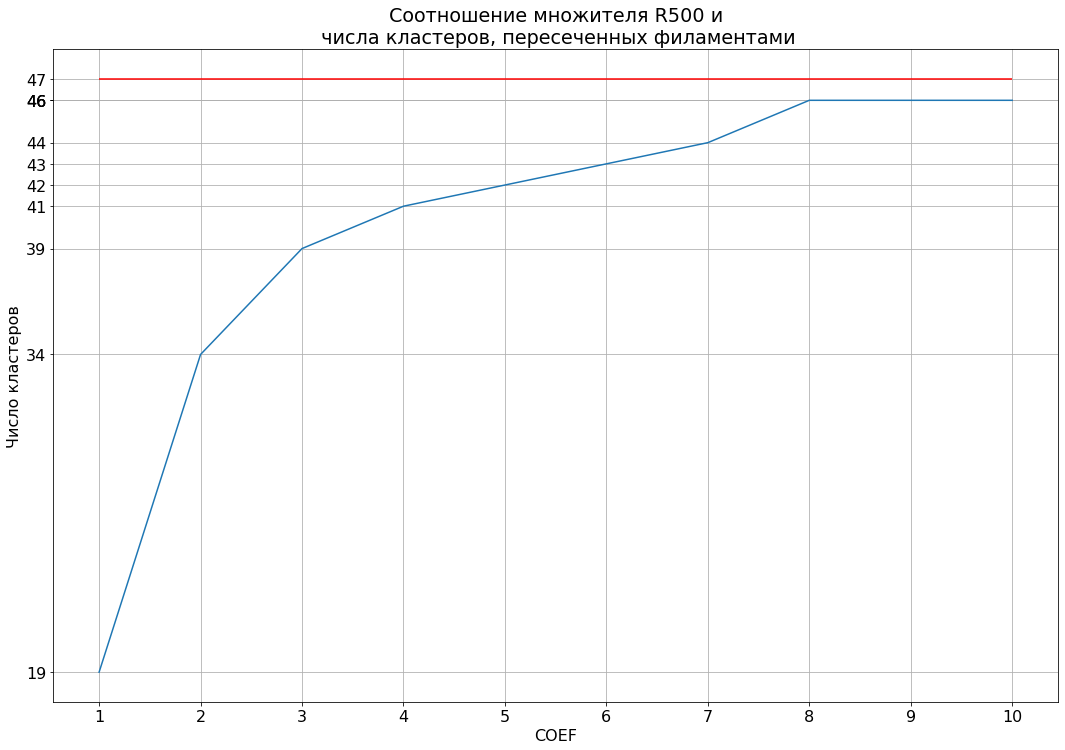

In [51]:
%matplotlib inline

coefs = list(num_conn_clasters.keys())
nums = list(num_conn_clasters.values())

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))

plt.plot(coefs, nums)
plt.hlines(clusters.shape[0], min(coefs), max(coefs), color='r')
plt.grid()

plt.xticks(np.arange(min(coefs), max(coefs)+1, 1))
plt.yticks(nums + [clusters.shape[0]])
plt.xlabel('COEF')
plt.ylabel('Число кластеров')
plt.title(f'Соотношение множителя R500 и\n числа кластеров, пересеченных филаментами')
plt.savefig(f'COEF*R500 -- conn_clusters', format='jpg')

In [62]:
RAD_FIL_COEF = 3
RAD_MAX_COEF = 3

conn = [0] * clusters.shape[0]
corr_max = [0] * clusters.shape[0]
count_fils = 0
count_maxs = 0
for fil in fils:
    fil['count'] = 0
for m in maxs:
    m['count'] = 0
for i in range(clusters.shape[0]):
    x3 = clusters.iloc[i]['CX']
    y3 = clusters.iloc[i]['CY']
    z3 = clusters.iloc[i]['CZ']
#     r_fil = 1.5
    r_fil = clusters.iloc[i]['R500'] * RAD_FIL_COEF
    r_max = clusters.iloc[i]['R500'] * RAD_MAX_COEF
    for j, fil in enumerate(fils):
        points = fil['sample_points']
        for l in range(len(points)-1):
            x1, y1, z1 = points[l]['CX'], points[l]['CY'], points[l]['CZ']
            x2, y2, z2 = points[l+1]['CX'], points[l+1]['CY'], points[l+1]['CZ']
            if intersec_line_sphere(
                x1, y1, z1,
                x2, y2, z2,
                x3, y3, z3,
                r_fil
            ):
                fil['count'] = fil['count'] + 1
                count_fils += 1
                conn[i] += 1
                break
    
                        
    for j, m in enumerate(maxs):
        if dist(m['CX'], m['CY'], m['CZ'],
               x3, y3, z3) <= r_max:
            m['count'] += 1
            count_maxs += 1
            corr_max[i] += 1
    
clusters = clusters.assign(conn=conn)
clusters = clusters.assign(corr_max=corr_max)
print(len(fils), count_fils)
print(len(maxs), count_maxs)

1060 74
1510 20


In [54]:
clusters['conn'].astype(bool).sum(), clusters.shape[0]

(40, 47)

In [55]:
clusters['corr_max'].astype(bool).sum(), clusters.shape[0]

(16, 47)

In [56]:
clusters

,name,alt_name,RA,DEC,Z,lx_500,mass_50,R500,CX,CY,CZ,conn,corr_max
0,MCXC J1231.0+0037,RXC J1231.0+0037,187.773333,0.628889,0.0232,2.234600e+42,1.981000e+13,0.4084,-101.1340,-13.80570,1.120410,2,1
1,MCXC J0920.0+0102,RXC J0920.0+0102,140.002083,1.040000,0.0175,1.174900e+42,1.344000e+13,0.3594,-59.0550,49.54940,1.399420,3,0
2,MCXC J1058.1+0135,RXC J1058.1+0135,164.543333,1.586389,0.0398,8.381300e+42,4.388000e+13,0.5296,-168.0620,46.47090,4.829110,6,3
3,MCXC J1506.4+0136,RXC J1506.4+0136,226.624167,1.605000,0.0060,1.106700e+42,1.305000e+13,0.3572,-18.1962,-19.25820,0.742384,1,1
4,MCXC J1058.2+0136,BVH2007 118,164.552917,1.615833,0.0385,6.677800e+42,3.823000e+13,0.5060,-162.6280,44.93900,4.759510,1,0
5,MCXC J1511.5+0145,RXC J1511.5+0145,227.889583,1.764167,0.0384,8.017700e+42,4.275000e+13,0.5252,-112.8390,-124.83600,5.182930,3,1
6,MCXC J1204.4+0154,RXC J1204.4+0154,181.105000,1.900556,0.0199,1.671220e+43,6.772000e+13,0.6158,-87.5615,-1.68890,2.906110,1,1
7,MCXC J1440.6+0328,RXC J1440.6+0328,220.159167,3.476389,0.0263,1.925670e+43,7.352000e+13,0.6316,-88.2115,-74.43680,7.011730,1,0
8,MCXC J1516.7+0701,RXC J1516.7+0701,229.183333,7.018611,0.0353,1.442058e+44,2.494500e+14,0.9465,-100.4750,-116.33400,18.924700,1,0
9,MCXC J1523.0+0836,RXC J1523.0+0836,230.772500,8.602500,0.0355,1.138819e+44,2.159800e+14,0.9020,-97.3867,-119.29100,23.296500,1,0


In [57]:
coma_name = 'MCXC J1259.7+2756'
coma_info = clusters[clusters.name == coma_name]
coma_cx, coma_cy, coma_cz = tuple(coma_info[['CX', 'CY', 'CZ']].values[0])
v_r = 2.86
counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
for cp in cps:
    if dist(coma_cx, coma_cy, coma_cz,
           cp['CX'], cp['CY'], cp['CZ']) <= v_r:
        counts[cp['type']] += 1
print(f'Mininum: {counts[0]}')
print(f'Saddle-1: {counts[1]}')
print(f'Saddle-2: {counts[2]}')
print(f'Maximum: {counts[3]}')
print(f'Bifurcation: {counts[4]}')

Mininum: 0
Saddle-1: 0
Saddle-2: 0
Maximum: 1
Bifurcation: 0


100%|██████████| 1060/1060 [00:00<00:00, 2359.40it/s]


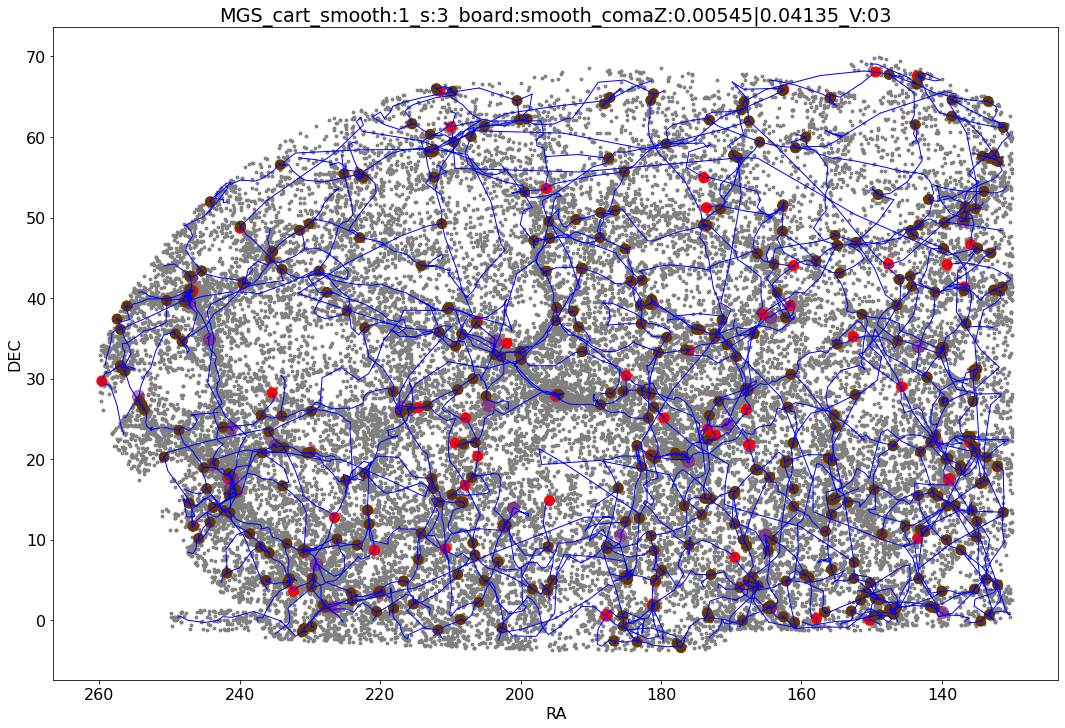

In [58]:
%matplotlib inline

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))

plt.scatter(coma['RA'], coma['DEC'], c='grey', s=8)

plt.scatter(clusters['RA'], clusters['DEC'], color='purple', s=150, alpha=0.5)

d = {4: 'xkcd:brown', 3: 'red', 2: 'green', 1: 'orange', 0: 'blue'}
x = []
y = []
c = []
for cp in cps:
    if cp['type'] != 3 and cp['type'] != 4:
        continue
    x.append(cp['RA'])
    y.append(cp['DEC'])
    c.append(d[cp['type']])
# print(len(x))
plt.scatter(x, y, c=c, s=100)

for fil in tqdm(fils):
#     if fil['count'] == 0:
#         continue
    points = fil['sample_points']
    x = []
    y = []
    for i in range(len(points)):
        x.append(points[i]['RA'])
        y.append(points[i]['DEC'])
    plt.plot(x, y, 'b', linewidth=1)
    
ax = fig.get_axes()
ax[0].invert_xaxis()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title(f'MGS_cart_smooth:{SMOOTH}_s:{SIGMA}_board:{BOARD}_comaZ:{coma_z_int[0]}|{coma_z_int[1]}_V:{VERSION}')
plt.savefig(f'MGS_cart_smooth:{SMOOTH}_s:{SIGMA}_board:{BOARD}_comaZ:{coma_z_int[0]}|{coma_z_int[1]}_V:{VERSION}', format='jpg')

In [59]:
%matplotlib widget
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

100%|██████████| 1060/1060 [00:00<00:00, 1963.12it/s]


Text(0.5, 0.92, 'MGS_cart_smooth:1_s:3_board:smooth_comaZ:0.00545|0.04135_V:03')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
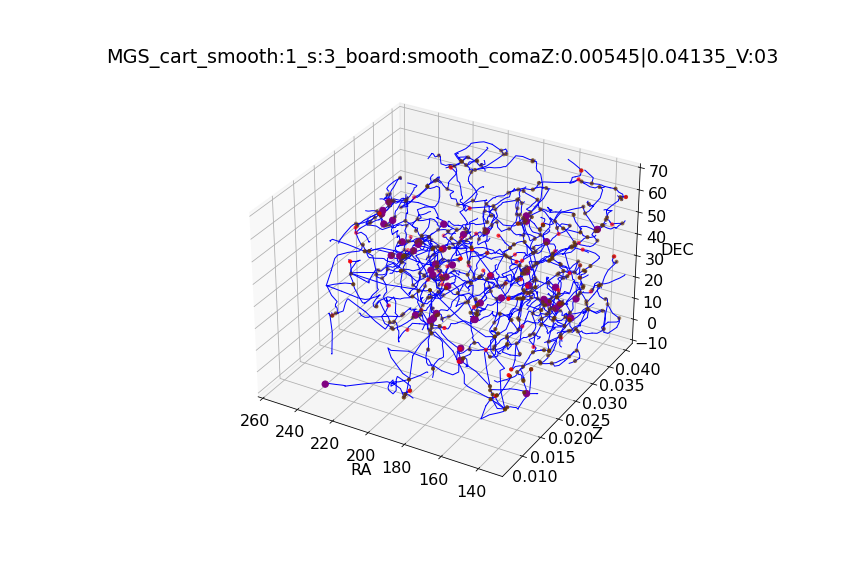

In [60]:
%matplotlib widget
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(coma_ra_int)
ax.set_zlim(coma_dec_int)
ax.set_ylim(coma_z_int)

# ax.scatter(coma['RA'], coma['Z'], coma['DEC'], c='grey', s=2, alpha=0.3)

d = {4: 'xkcd:brown', 3: 'red', 2: 'green', 1: 'orange', 0: 'blue'}
x = []
y = []
z = []
c = []
for cp in cps:
    if cp['type'] != 3 and cp['type'] != 4:
        continue
    x.append(cp['RA'])
    y.append(cp['DEC'])
    z.append(cp['Z'])
    c.append(d[cp['type']])
ax.scatter(x, z, y, c=c, s=10)

for fil in tqdm(fils):
#     if fil['count'] == 0:
#         continue
    points = fil['sample_points']
    x = []
    y = []
    z = []
    for i in range(len(points)):
        x.append(points[i]['RA'])
        y.append(points[i]['DEC'])
        z.append(points[i]['Z'])
    ax.plot(x, z, y, 'b', linewidth=1)
    
ax.scatter(clusters['RA'], clusters['Z'], clusters['DEC'], color='purple', s=40, alpha=1)

ax.invert_xaxis()
ax.set_xlabel('RA')
ax.set_ylabel('Z')
ax.set_zlabel('DEC')
ax.set_title(f'MGS_cart_smooth:{SMOOTH}_s:{SIGMA}_board:{BOARD}_comaZ:{coma_z_int[0]}|{coma_z_int[1]}_V:{VERSION}')